In [3]:
import torch
import torch.nn as nn

In [4]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [5]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [19]:
from torchvision import datasets
from torchvision import transforms
data_path = './data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [20]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [21]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

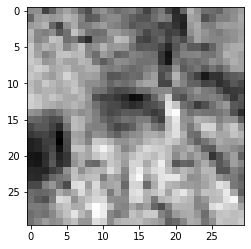

In [26]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

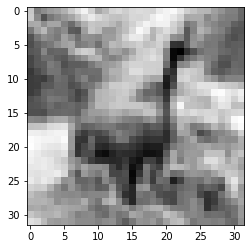

In [27]:
plt.imshow(img[0].detach(), cmap='gray')
plt.show()

In [28]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [29]:
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

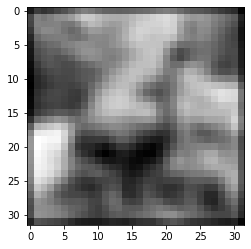

In [31]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [32]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
    [-1.0, 0.0, 1.0],
    [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

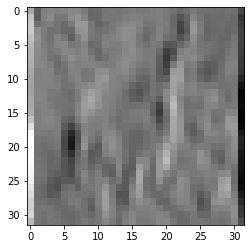

In [33]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [34]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [39]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [41]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [50]:
torch.max(model(img.unsqueeze(0).cuda()), dim=1)

torch.return_types.max(
values=tensor([1.1698], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))

In [46]:
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        model.cuda()

        for imgs, labels in train_loader:
            
            outputs = model(imgs.cuda())
            loss = loss_fn(outputs, labels.cuda())
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True,)

model = Net()

learning_rate = 1e-5
 
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
 
loss_fn = nn.CrossEntropyLoss()
 
n_epochs = 100
 
training_loop(n_epochs, optimizer, model, loss_fn, train_loader)

2020-09-05 08:32:48.845758 Epoch 1, Training loss 0.6975124447968355
2020-09-05 08:32:51.987390 Epoch 10, Training loss 0.5927391382539349
2020-09-05 08:32:55.472147 Epoch 20, Training loss 0.4894361057478911
2020-09-05 08:32:59.123941 Epoch 30, Training loss 0.4220984986253605
2020-09-05 08:33:02.499490 Epoch 40, Training loss 0.37830611427498473
2020-09-05 08:33:05.906759 Epoch 50, Training loss 0.35677301560997204
2020-09-05 08:33:09.251641 Epoch 60, Training loss 0.3439393811354971
2020-09-05 08:33:12.602433 Epoch 70, Training loss 0.3340907197469359
2020-09-05 08:33:15.978352 Epoch 80, Training loss 0.32504300175199086
2020-09-05 08:33:19.306795 Epoch 90, Training loss 0.32201054303129767
2020-09-05 08:33:22.676124 Epoch 100, Training loss 0.31537944809266716


In [52]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    model.cuda()
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs.cuda())
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted.cpu() == labels).sum())
        
        print('Accuracy {}:{:.2f}'.format(name, correct / total))

In [53]:
validate(model, train_loader, val_loader)

Accuracy train:0.87
Accuracy val:0.85


In [54]:
torch.save(model.state_dict(), './model/birds_vs_airplanes.pt')

In [55]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load('./model/birds_vs_airplanes.pt'))

<All keys matched successfully>

In [56]:
#加入L2损失
def training_loop_l2(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        model.cuda()

        for imgs, labels in train_loader:
            
            outputs = model(imgs.cuda())
            loss = loss_fn(outputs, labels.cuda())
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss += l2_lambda * l2_norm
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [ ]:
#加入Dropout
#通过model.train()和model.eval()控制dropout激活情况
class NetDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout2d(0.4)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout2d(0.4)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.drop1(out)
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.drop2(out)
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out    